In [3]:
pip install cifar10

In [2]:
import cifar10
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
X_test, y_test = [], []
for img, lbl in cifar10.test_batch_generator():
    X_test.append(img)
    y_test.append(lbl)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test:", X_test.shape, y_test.shape)

Test: (150000, 32, 32, 3) (150000,)


In [4]:
label_map = cifar10.image_label_map()
class_names = [label_map[i] for i in range(len(label_map))]
print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
X_train, y_train = [], []
for img, lbl in cifar10.data_batch_generator():
    X_train.append(img)
    y_train.append(lbl)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Train:", X_train.shape, y_train.shape)

Train: (150000, 32, 32, 3) (150000,)


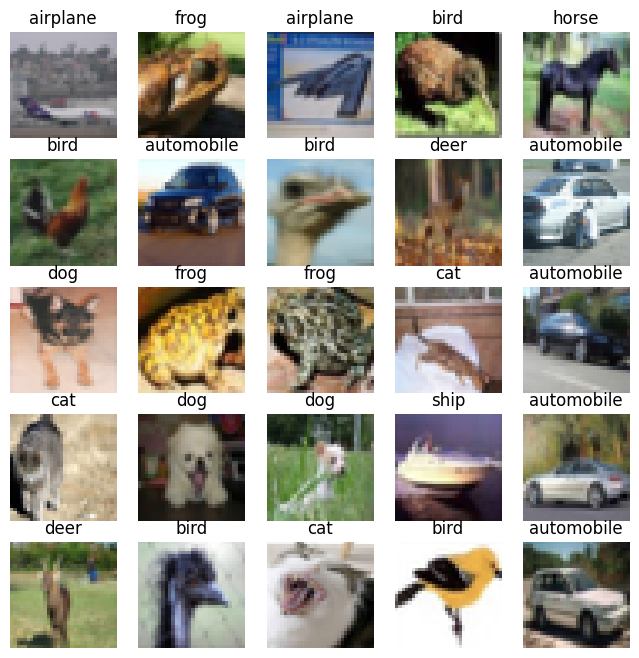

In [6]:
fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis("off")
plt.show()

In [7]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print("Flattened shapes:", X_train_flat.shape, X_test_flat.shape)

Flattened shapes: (150000, 3072) (150000, 3072)


In [8]:
X_train_flat=X_train_flat[0:50000,:]
X_test_flat=X_test_flat[0:10000,:]
pca = PCA(whiten=True)
pca.fit(X_train_flat)

k = 0
current = 0
total = sum(pca.explained_variance_)
while current/total < 0.99:
    current += pca.explained_variance_[k]
    k += 1
print("Num components:", k)

pca_cifar = PCA(n_components=k, whiten=True)
X_train_pca = pca_cifar.fit_transform(X_train_flat)
X_test_pca = pca_cifar.transform(X_test_flat)

print(X_train_pca.shape, X_test_pca.shape)

Num components: 647
(50000, 647) (10000, 647)


In [9]:
clf1 = RandomForestClassifier(n_estimators=200, n_jobs=-1)
clf2 = LogisticRegression(max_iter=200, n_jobs=-1)
clf3 = KNeighborsClassifier(n_jobs=-1)
clf4 = SVC()

clfs = [clf1, clf2, clf3, clf4]

In [11]:
for clf in clfs:
    clf.fit(X_train_pca, y_train[0:50000])
    print(clf.__class__.__name__, "trained")

RandomForestClassifier trained
LogisticRegression trained
KNeighborsClassifier trained
SVC trained


In [12]:
preds = [clf.predict(X_test_pca) for clf in clfs]

In [14]:
y_test=y_test[0:10000]
ans = []
for i in range(len(y_test)):
    votes = [pred[i] for pred in preds]
    ans.append(np.bincount(votes).argmax())
ans = np.array(ans)

In [15]:
from sklearn.metrics import accuracy_score

for i, clf in enumerate(clfs, 1):
    print(f"{clf.__class__.__name__} accuracy:",
          accuracy_score(y_test, preds[i-1]))

print("Ensemble accuracy:", accuracy_score(y_test, ans))

RandomForestClassifier accuracy: 1.0
LogisticRegression accuracy: 0.5124
KNeighborsClassifier accuracy: 1.0
SVC accuracy: 0.9787
Ensemble accuracy: 0.9909


In [18]:
import pandas as pd

ans_labels = [class_names[i] for i in ans]

df = pd.DataFrame({
    "y_pred": ans_labels
})

df.to_csv("cifar10_ensemble_predictions.csv", index=False, header=False)
print("Predictions saved to cifar10_ensemble_predictions.csv")

Predictions saved to cifar10_ensemble_predictions.csv
